In [2]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "04_problem_types/10g_scann_search.ipynb"
_nb_title = "Searching for embeddings"
_nb_message = """
This notebook shows you how to use embeddings and SCaNN to implement fast image search.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Searching+for+embeddings&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_problem_types%2F10g_scann_search.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_problem_types/10g_scann_search.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Searching for embeddings</h1>
This notebook shows you how to use embeddings and SCaNN to implement fast image search.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%pip install --quiet scann tensorflow-addons

In [ ]:
import scann
import tensorflow as tf
import tensorflow_addons as tfa

print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    pass
    # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Create index of embeddings

Use a pre-trained MobileNet model to create embeddings
of 100 images in the flowers dataset.

In [23]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import scann
import os

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
NUM_IMAGES = 100
NUM_NEIGH = 3 # top 3
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return filename, img, label, label_string

In [3]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
print(model.summary())

Model: "flowers_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [4]:
def create_embeddings_dataset(embedder, csvfilename, num_images):
  ds = (tf.data.TextLineDataset(csvfilename).
        map(decode_csv).take(num_images).batch(BATCH_SIZE))
  dataset_filenames = []
  dataset_embeddings = []
  for filenames, images, _, _ in ds:
    embeddings = embedder(images)
    dataset_filenames.extend([f.numpy().decode('utf-8') for f in filenames])
    dataset_embeddings.extend(embeddings)
  dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  return dataset_filenames, dataset_embeddings

dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://cloud-ml-data/img/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # should be (NUM_IMAGES, 1280)

['gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 1280)


In [5]:
query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv", 2
)
print(query_embeddings.shape)

(2, 1280)


In [6]:
## Create SCaNN searcher
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()

In [7]:
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[36 42 11]
 [95 26 27]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[390.5546  379.76334 356.1113 ]
 [457.37134 362.77057 336.50153]], shape=(2, 3), dtype=float32)


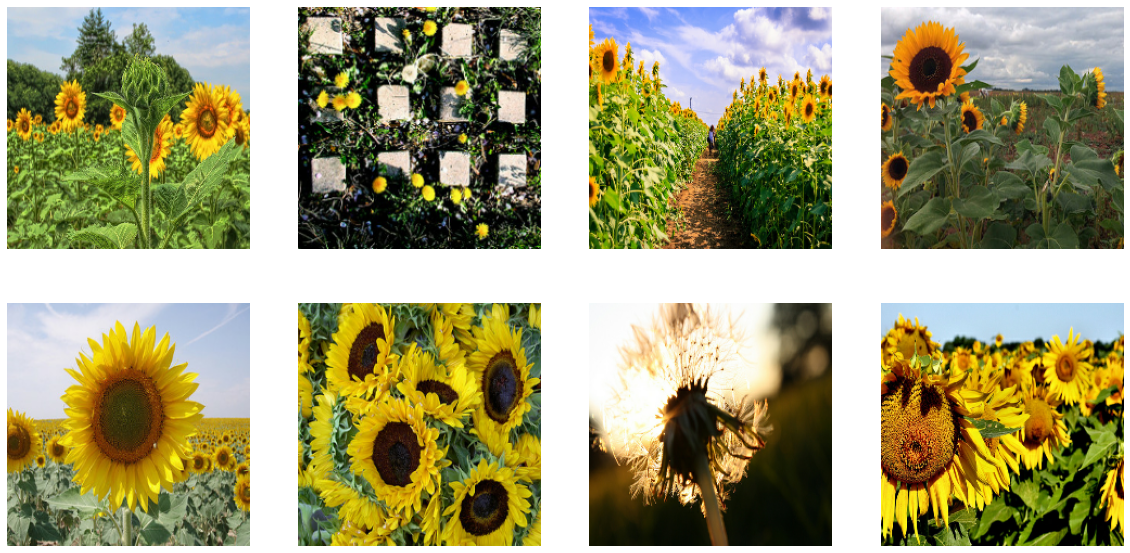

In [8]:
f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                     figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
for rowno, query_filename in enumerate(query_filenames):
  ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
  ax[rowno][0].axis('off')
  for colno, neigh in enumerate(neighbors[rowno]):
    ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
    ax[rowno][colno+1].set_xlabel('dist={:.1f}'.format(distances[rowno][colno].numpy()))
    ax[rowno][colno+1].axis('off')

## Triplet Loss

Here we train an embedding based on the classification task.
Because the goal is an embedding rather than classification, we'll use the triplet loss,
specifically the semihard triplet.

See also:
* https://arxiv.org/pdf/1503.03832.pdf
* https://www.tensorflow.org/addons/tutorials/losses_triplet
* https://omoindrot.github.io/triplet-loss

Note:
The triplet loss is defined in such a way that if there is not a positive pair in *each* of the batches, we will end up with NaN.
Our batch size has to be large enough that this doesn't happen.

In [28]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(5, activation=None, name='dense_5'),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='normalize_embeddings')
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
print(model.summary())

Model: "flowers_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
_________________________________________________________________
normalize_embeddings (Lambda (None, 5)                 0         
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [42]:
# training on just 32*10 images, not full dataset
train_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv").
    map(decode_csv)).take(BATCH_SIZE*10).map(lambda path, img, lint, ls: (img, lint)).batch(BATCH_SIZE)
history = model.fit(train_dataset, epochs=5)

Epoch 1/5
10/10 [==============================] - 44s 4s/step - loss: 0.5555
Epoch 2/5
10/10 [==============================] - 41s 4s/step - loss: 0.4771
Epoch 3/5
10/10 [==============================] - 40s 4s/step - loss: 0.4092
Epoch 4/5
10/10 [==============================] - 40s 4s/step - loss: 0.3441
Epoch 5/5
10/10 [==============================] - 40s 4s/step - loss: 0.2798


In [43]:
# repeat with new model
dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://cloud-ml-data/img/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # should be (NUM_IMAGES, 5)

query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv", 2
)
print(query_embeddings.shape)

['gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 5)
(2, 5)


In [44]:
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[79 18 24]
 [31 58 20]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[0.7202287  0.6966918  0.6966918 ]
 [0.81558436 0.81558436 0.791311  ]], shape=(2, 3), dtype=float32)


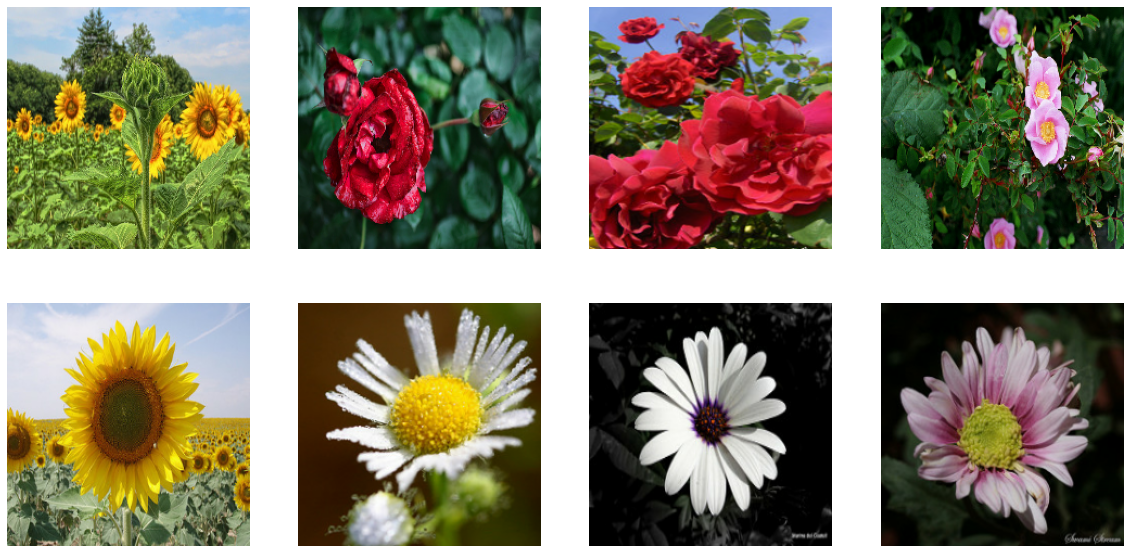

In [45]:
f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                     figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
for rowno, query_filename in enumerate(query_filenames):
  ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
  ax[rowno][0].axis('off')
  for colno, neigh in enumerate(neighbors[rowno]):
    ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
    ax[rowno][colno+1].set_xlabel('dist={:.1f}'.format(distances[rowno][colno].numpy()))
    ax[rowno][colno+1].axis('off')

## View embeddings in projector

Create files to view in https://projector.tensorflow.org/

In [47]:
import io
import tensorflow_datasets as tfds

test_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv").
    map(decode_csv)).map(lambda path, img, lint, ls: (img, lint)).take(NUM_IMAGES).batch(1)
test_results = model.predict(test_dataset)
np.savetxt("vecs.tsv", test_results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(CLASS_NAMES[x] + "\n") for x in labels]
out_m.close()

<img width="600" src="embedding_projection.png" />

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.